In [1]:
#!/usr/bin/env python
# coding: utf-8

import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import copy

from climada.util import coordinates as u_coords
import analysis.analysis_funcs as af
import analysis.plotting_funcs as pf


In [93]:
        
# =============================================================================
# Compute results
# =============================================================================

if __name__ == '__main__': 
    
    """
    produces and saves the following plots:
        *
        *
        *
    produces and saves the following dataframes:
        *
        *
    produces and saves the following tex-file:
        
    """

    # Variable definitions
    cntry = 'Vietnam'
    haz_type = 'TC'
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_save_plots = path_cntry_folder+'plots/'
    path_nodes = path_cntry_folder+'cis_nw_nodes'
    path_event_stats = path_cntry_folder+f'service_stats_{haz_type}_{iso3}.pkl'
    path_base_stats = path_cntry_folder+f'base_stats_{iso3}.pkl'
    
    # new folders to be created
    if not os.path.exists(path_save_plots):
        os.makedirs(path_save_plots)
    if not os.path.exists(path_cntry_folder+'old/'):
        os.makedirs(path_cntry_folder+'old/')
    if not os.path.exists(path_cntry_folder+'small_events/'):
        os.makedirs(path_cntry_folder+'small_events/')

    

In [94]:
    #load files 
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    base_stat_dict = af.load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    event_stat_dict = af.load_dict(path_event_stats)

In [96]:
# amend forgotten people stats
if 'people' not in list(event_stat_dict.values())[0].keys():
    dict_gdfs = af.load_gdf_dict(path_cntry_folder, haz_type, valid_events=list(event_stat_dict.keys()))
    for event_id, stats_dict in event_stat_dict.items():
        event_stat_dict[event_id]['people'] = dict_gdfs[event_id][dict_gdfs[event_id].ci_type=='people'].imp_dir.sum()

    af.save_dict(event_stat_dict, path_event_stats)
    

In [97]:
    # create summary dictionaries for basic service attainment
    access_rate_dict = af.access_rate_conversion(
        base_stat_dict, gdf_nodes_orig, abs_num=False)
    access_num_dict = af.access_rate_conversion(
        base_stat_dict, gdf_nodes_orig, abs_num=True)
    
    # pre-select for small events and move them for now
    disr_rate_dict = af.disruption_rate_conversion(
        event_stat_dict, access_num_dict)
    
    cutoff_popimp = 0.001 if haz_type=='TC' else 0.0001


In [99]:
    drop_events = af.select_insignificant_events(disr_rate_dict, cutoff_popimp)
    
    small_disr_rate_dict = {}
    small_event_stat_dict = {}
    for event_id in drop_events:
        small_disr_rate_dict[event_id] = disr_rate_dict[event_id]
        del disr_rate_dict[event_id]
        small_event_stat_dict[event_id] = event_stat_dict[event_id]
        del event_stat_dict[event_id]
    
    af.move_gdfs(path_cntry_folder, haz_type, 
                 valid_events=list(event_stat_dict.keys()),
                 small_events=list(small_event_stat_dict.keys()))
    
    dict_gdfs = af.load_gdf_dict(path_cntry_folder, haz_type, 
                                 valid_events=list(event_stat_dict.keys()))
    
    destruction_rate_dict = af.destruction_rate_conversion(dict_gdfs)
    af.save_dict(event_stat_dict, path_event_stats)
    af.save_dict(disr_rate_dict, path_cntry_folder+f'disruption_rates_{iso3}_{haz_type}.pkl')
    af.save_dict(destruction_rate_dict, path_cntry_folder+f'destruction_rates_{iso3}_{haz_type}.pkl')

    

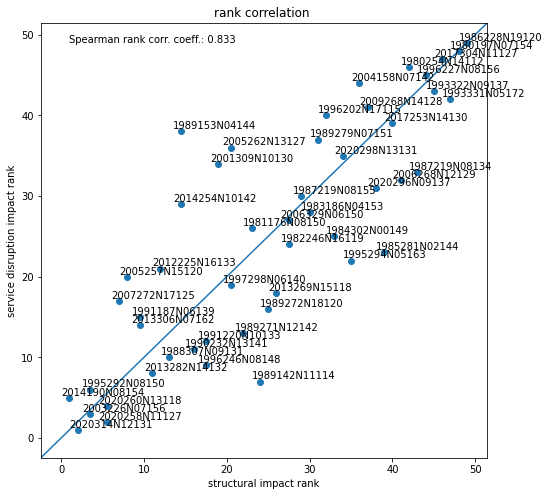

In [100]:
    # correlation analysis
    spearmanr_res, ranklist = af.compare_impact_rankings(disr_rate_dict, destruction_rate_dict)
    pf.plot_rank_correlation(ranklist, spearmanr_res, 
                             list(event_stat_dict.keys()), 
                             haz_type=haz_type, save_path=path_save_plots)


In [101]:
    # aggregating event results
    for key, gdf in dict_gdfs.items():
        save_path = path_cntry_folder + f'cascade_results_{key}'
        dict_gdfs[key] = af.get_casc_and_access_states(gdf, gdf_nodes_orig, save_path=save_path)


Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already performed. Aborting
Cascade and access analysis was already 

In [102]:
    if len(dict_gdfs.keys())>1:
        gdf_summed = af.sum_impacts(
            [gdf for gdf in dict_gdfs.values()], 
            save_path=path_cntry_folder+f'summed_impacts_{haz_type}_{iso3}')
    else:
        gdf_summed = list(dict_gdfs.values())[0]
        gdf_summed = gdf_summed[gdf_summed.ci_type=='people'].iloc[:,3:]

/cluster/home/evelynm/scripts/gobal-service-disruptions/main_scripts/analysis/analysis_funcs.py:268: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf_services.to_feather(save_path)


In [103]:
gdf_summed_popweighted = af.sum_impacts_popweighted(
        gdf_summed, 
        save_path=path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}')


/cluster/home/evelynm/scripts/gobal-service-disruptions/main_scripts/analysis/analysis_funcs.py:286: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf_summed_popweighted.to_feather(save_path)


/scratch/tmp.10710755.evelynm/ipykernel_130626/2023494898.py:36: RuntimeWarning: invalid value encountered in double_scalars
  perevent_factor_b[event_id][service] = np.round(np.abs(lost_service/lost_service_affected),2)
/scratch/tmp.10710755.evelynm/ipykernel_130626/2023494898.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  perevent_factor_b[event_id][service] = np.round(np.abs(lost_service/lost_service_affected),2)
/scratch/tmp.10710755.evelynm/ipykernel_130626/2023494898.py:36: RuntimeWarning: invalid value encountered in double_scalars
  perevent_factor_b[event_id][service] = np.round(np.abs(lost_service/lost_service_affected),2)
/scratch/tmp.10710755.evelynm/ipykernel_130626/2023494898.py:36: RuntimeWarning: invalid value encountered in double_scalars
  perevent_factor_b[event_id][service] = np.round(np.abs(lost_service/lost_service_affected),2)
/scratch/tmp.10710755.evelynm/ipykernel_130626/2023494898.py:36: RuntimeWarning: invalid value encountered in doubl

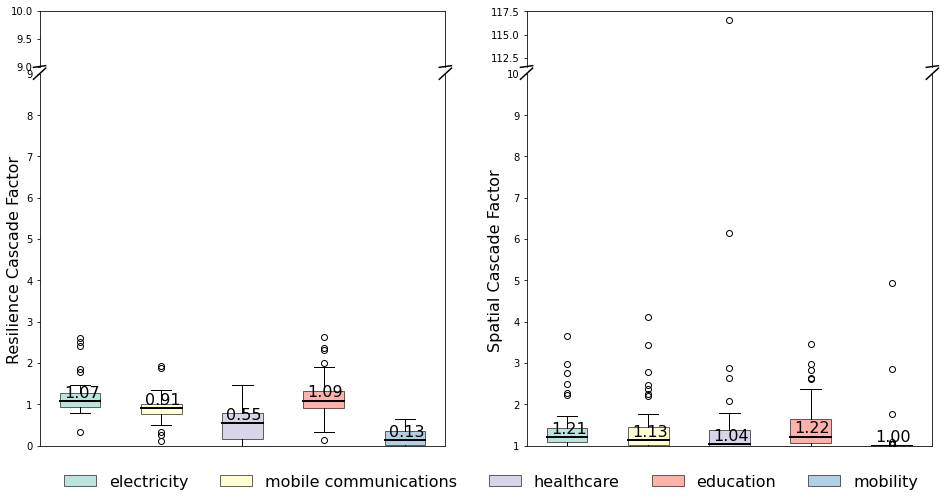

2023-02-24 15:33:06,741 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2022-05-03 17:22:57 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /cluster/work/climate/evelynm/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2023-02-24 15:33:08,068 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2022-05-03 17:22:57 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /cluster/work/climate/evelynm/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2023-02-24 15:33:09,329 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2022-05-03 17:22:57 (older than 180 days). Very likely, a more rec

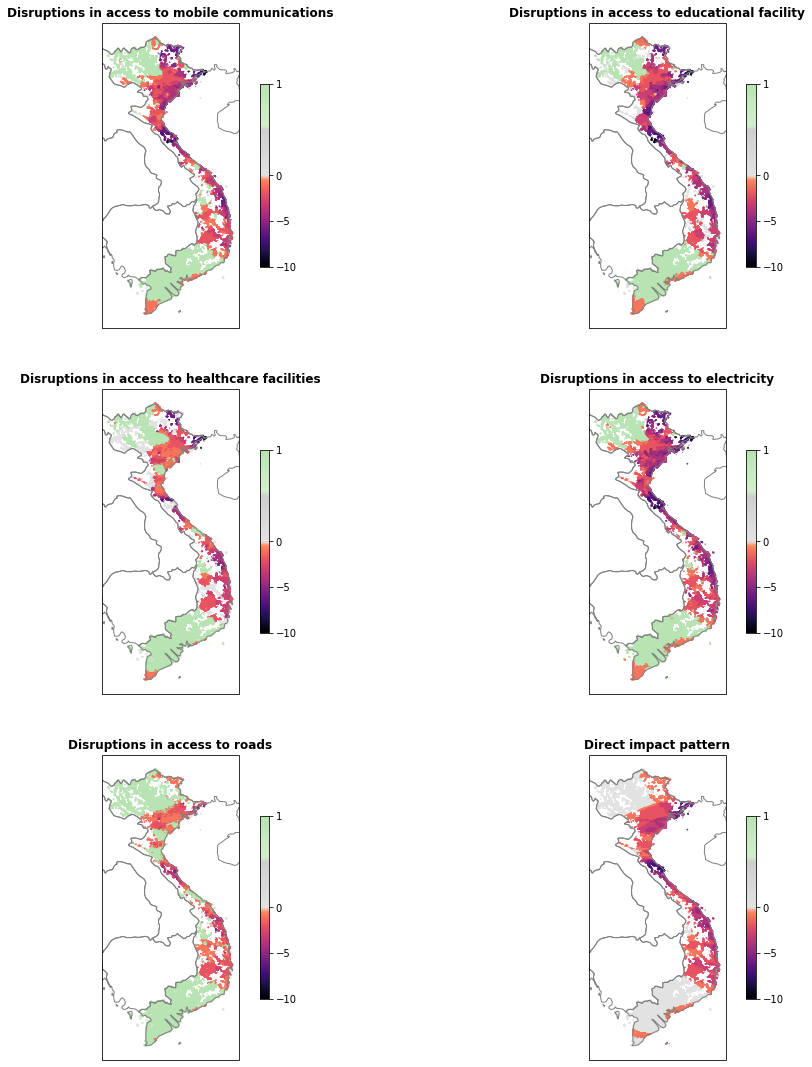

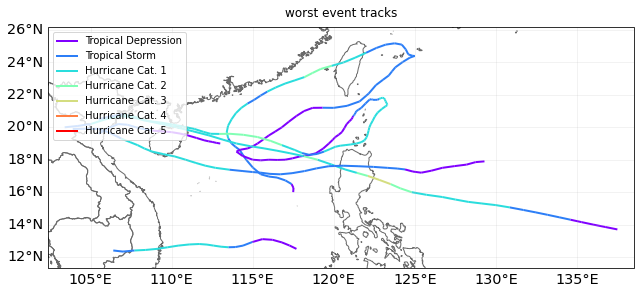

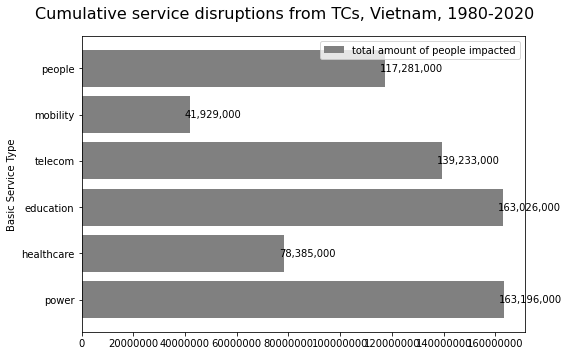

In [104]:

    total_imps = af.get_total_imps(event_stat_dict)
    af.save_dict(total_imps, path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')

    # Factor C per event  & median (pop without service / pop with initial service access in dir. aff. region)
    perevent_factor_c = {}
    
    for event_id, imp_gdf in dict_gdfs.items():
        perevent_factor_c[event_id] = {}
        imp_gdf = imp_gdf[imp_gdf.ci_type=='people']
        for variable, service in af.service_dict().items():
            lost_service = imp_gdf[imp_gdf[variable]<0]['counts'].sum()
            # has or had service, in directly affected area
            had_service_affected = imp_gdf[(imp_gdf['imp_dir']>0) & (imp_gdf[variable]!=0)]['counts'].sum()
            perevent_factor_c[event_id][service] = np.round(np.abs(lost_service/had_service_affected),2)
            if lost_service==0:
                perevent_factor_c[event_id][service] = 0
        perevent_factor_c[event_id]['population'] = imp_gdf[(imp_gdf['imp_dir']>0)]['counts'].sum()/imp_gdf['counts'].sum()
    
    # convert to dataframe    
    df_factor_c = pd.DataFrame.from_dict(perevent_factor_c)
    df_factor_c['median'] = df_factor_c.apply(lambda row: np.nanmedian(row.values), axis=1)    
    df_factor_c.to_csv(path_cntry_folder+f'perevent_factor_c_{iso3}_{haz_type}.csv')


    # Factor B per event  & median (pop without service / pop without service in dir. aff. region)
    perevent_factor_b = {}
    
    for event_id, imp_gdf in dict_gdfs.items():
        perevent_factor_b[event_id] = {}
        imp_gdf = imp_gdf[imp_gdf.ci_type=='people']
        for variable, service in af.service_dict().items():
            # lost service anywhere
            lost_service = imp_gdf[imp_gdf[variable]<0]['counts'].sum()
            # lost service in directly affected area
            lost_service_affected = imp_gdf[(imp_gdf['imp_dir']>0) & (imp_gdf[variable]<0)]['counts'].sum()
            perevent_factor_b[event_id][service] = np.round(np.abs(lost_service/lost_service_affected),2)
            if lost_service==0:
                perevent_factor_c[event_id][service] = 0
        perevent_factor_b[event_id]['population'] = imp_gdf[(imp_gdf['imp_dir']>0)]['counts'].sum()/imp_gdf['counts'].sum()
    # convert to dataframe    
    df_factor_b = pd.DataFrame.from_dict(perevent_factor_b)
    df_factor_b['median'] = df_factor_b.apply(lambda row: np.nanmedian(row.values), axis=1)    
    df_factor_b.to_csv(path_cntry_folder+f'perevent_factor_b_{iso3}_{haz_type}.csv')
    
    
    # overview plots cumulative services (summary and spatially explicit)
    pf.casc_factor_boxplots(df_factor_c, df_factor_b, haz_type, save_path=path_save_plots)
    pf.service_cumimpact_plot(gdf_summed, haz_type=haz_type, save_path=path_save_plots)
    
    worst_events_s = [worst[1] for worst in 
                      af.get_worst_events(disr_rate_dict, n_min=int(3), 
                                          mode='service')]
    worst_events_f = [worst[1] for worst in 
                      af.get_worst_events(destruction_rate_dict, n_min=int(3), 
                                          mode='functionality')]
    
    if haz_type=='TC':
        pf.plot_worst_tc_tracks(worst_events_s,
                                save_path=path_save_plots)
    elif haz_type=='FL':
        pf.plot_worst_floods(worst_events_s, path_cntry_folder, iso3, 
                             save_path=path_save_plots)
    
    div_events = af.get_diverging_events(event_stat_dict, ranklist)
    
    pf.plot_total_impacts_bars(total_imps, haz_type, cntry, save_path=path_save_plots)

In [105]:
    # =============================================================================
    # Create a summary-pdf document with most important outputs
    # =============================================================================
    
    # heavily uses pylatex package 
    
    from pylatex import Document, Section, Subsection, Tabular, Figure, MiniPage,LargeText, LineBreak
    from pylatex.utils import bold
    import os
    
    # define necessary save and lookup paths
    
    path_root = 'countries/' 
    #change this according to where it is called from - now expects .tex file & .png files in same folder countries/iso3/ 
    path_imp_cum_plot = path_root+f'service_disruptions_cum_{haz_type}.png'
    path_imp_tot_plot = path_root+f'tot_serv_impacts_bars_{haz_type}.png'
    path_rankstats = path_root+f'event_rankings_{haz_type}.png'
    path_cascfactor_bplots = path_root+f'cascfactor_boxplots_{haz_type}.png'
    worst_event_header_s = ['Event Name']
    worst_event_header_s.extend(list(base_stat_dict.keys()))
    worst_event_header_f = ['Event Name']
    worst_event_header_f.extend(list(list(destruction_rate_dict.values())[0].keys()))
    path_worst_event_plot = path_root+f'worst_events_{haz_type}.png'
    
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
    
    geometry_options = {"tmargin": "2cm", "lmargin": "2cm", "rmargin": "2cm"}
    doc = Document(geometry_options=geometry_options)
    
    # Add Heading
    with doc.create(MiniPage(align='c')):
        doc.append(LargeText(bold(f"Summary Output for {haz_type}s, {cntry}, {year_range}")))
        doc.append(LineBreak())
            
    with doc.create(Section('Base case: Access rates statistics')):
        with doc.create(Tabular('lllll')) as table:
            table.add_hline()
            table.add_row(list(base_stat_dict.keys())[:-1])
            table.add_hline()
            table.add_empty_row()
            table.add_row(np.round(np.array(list(access_rate_dict.values())[:-1])*100,1))
        doc.append(LineBreak())
        doc.append('Access rates to respective services (%)')

    with doc.create(Section('Cascade factors of service disruptions')):
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_cascfactor_bplots, width='350px')
            imp_pic.add_caption(f'Cascade factor metrics for servcice disruptions from {haz_type} {year_range}, {cntry}')

    with doc.create(Section('Cumulative service disruption impacts')): 
        doc.append(f'Number of {haz_type} events: {len(disr_rate_dict)}')
        
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_imp_tot_plot, width='250px')
            imp_pic.add_caption(f'People impacted by service disruptions from {haz_type} {year_range}, {cntry}')
            
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_imp_cum_plot, width='550px')
            imp_pic.add_caption(f'Spatial maps of service disruptions from {haz_type} {year_range}, {cntry}')
            
    with doc.create(Tabular('llllll')) as table:
            table.add_empty_row()
            table.add_empty_row()
            table.add_empty_row()
            table.add_empty_row()
        
    
    with doc.create(Section('Worst events overview')):
        with doc.create(Subsection('Worst event stats: Service Disruptions')):
            with doc.create(Tabular('lllllll')) as table:
                    table.add_hline()
                    table.add_row(worst_event_header_s)
                    table.add_hline()
                    table.add_empty_row()
                    for worst_event in worst_events_s:
                        table.add_row(list(np.append((worst_event), 
                                                     np.round(np.array(list(disr_rate_dict[worst_event].values()))*100,
                                                              1))))
                    table.add_empty_row()

            doc.append(LineBreak())
            doc.append('Worst events with respect to service access disruptions (%, relative to base state)')
        
        with doc.create(Subsection('Worst event stats: Direct Damages')):
            with doc.create(Tabular('lrrrrrr')) as table:
                    table.add_hline()
                    table.add_row(worst_event_header_f)
                    table.add_hline()
                    table.add_empty_row()
                    for worst_event in worst_events_f:
                        table.add_row(list(np.append((worst_event), 
                                                     np.round(np.array(list(destruction_rate_dict[worst_event].values())),
                                                              3))))
                    table.add_empty_row()
                    
            doc.append(LineBreak())
            doc.append('Worst events with respect to direct (structural) damages. In % relative to total units.')

            with doc.create(Figure(position='h!')) as imp_pic:
                imp_pic.add_image(path_worst_event_plot, width='350px')
                imp_pic.add_caption(f'Worst {haz_type} events, {cntry}')


            with doc.create(Subsection('Event ranks comparison')):
                with doc.create(Figure(position='htbp')) as imp_pic:
                    imp_pic.add_image(path_rankstats, width='350px')
                    imp_pic.add_caption('Comparison of event severeness ranks between direct impact metrics and service disruption metrics')
                doc.append('Most diverging events in ranking (> 20% rank difference):')
                doc.append(LineBreak())
                for event in list(div_events):
                    doc.append(event)
                    doc.append(LineBreak())
                

    doc.generate_tex(filepath=path_cntry_folder+f'summary_pages_{haz_type}_{iso3}')